In [ ]:
# | default_exp models.stsm

In [ ]:
# | export
import jax
import jax.numpy as jnp
from jaxtyping import Float, Array
from isssm.typing import GLSSM
import jax.scipy as jsp

In [ ]:
from isssm.glssm import simulate_glssm
import jax.random as jrn
import matplotlib.pyplot as plt
from isssm.kalman import kalman, smoother
from isssm.models.glssm import mv_ar1

# Basic Structural Time Series Model
> 2-nd order stationary time series with seasonal component

We implement the univariate model from Chapter 3.2.2 in [@Durbin2012Time] and refer the reader to their discussion.

In [ ]:
# | export
def stsm(
    x0: Float[Array, "m"],  # initial state
    s2_mu: Float,  # variance of trend innovations
    s2_nu: Float,  # variance of velocity innovations
    s2_seasonal: Float,  # variance of velocity innovations
    n: int,  # number of time points
    Sigma0: Float[Array, "m m"],  # initial state covariance
    o2: Float,  # variance of observation noise
    s_order: int,  # order of seasonal component
    alpha_velocity: Float = 1.0,  # dampening factor for velocity
) -> GLSSM:

    A = jnp.array([[1, 1], [0, alpha_velocity]])
    B = jnp.array([[1, 0]])

    Sigma = jnp.diag(jnp.array([s2_mu, s2_nu]))

    has_seasonality = s_order >= 2
    if has_seasonality:
        A_seasonal = jnp.block(
            [
                [-jnp.ones((1, s_order - 2)), -jnp.ones((1, 1))],
                [jnp.eye(s_order - 2), jnp.zeros((s_order - 2, 1))],
            ]
        )
        B_seasonal = (jnp.eye(s_order - 1)[0])[None, :]
        Sigma_seasonal = jnp.eye(1) * s2_seasonal

        A = jsp.linalg.block_diag(A, A_seasonal)
        B = jnp.concatenate((B, B_seasonal), axis=1)
        Sigma = jsp.linalg.block_diag(Sigma, Sigma_seasonal)

    l = 3 if has_seasonality else 2
    m = (s_order - 1) + 2 if has_seasonality else 2
    p = 1

    A = jnp.broadcast_to(A, (n, m, m))
    B = jnp.broadcast_to(B, (n + 1, p, m))
    D = jnp.broadcast_to(jnp.eye(m)[:, :l], (n, m, l))

    Sigma = jnp.broadcast_to(Sigma, (n, l, l))

    Omega = jnp.broadcast_to(jnp.diag(jnp.array([o2])), (n + 1, p, p))

    u = jnp.zeros((n + 1, m)).at[0].set(x0)
    v = jnp.zeros((n + 1, p))

    return GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

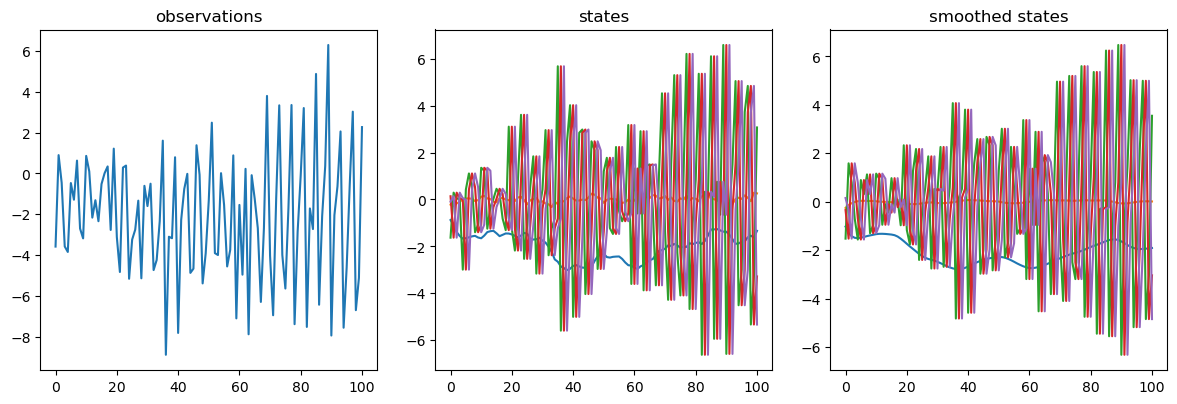

In [ ]:
s_ord = 4
glssm = stsm(
    jnp.zeros(2 + s_ord - 1),
    0.0,
    0.01,
    1.0,
    100,
    jnp.eye(2 + s_ord - 1),
    1.0,
    s_ord,
    0.5,
)
key = jrn.PRNGKey(534512423)
key, subkey = jrn.split(key)
(x,), (y,) = simulate_glssm(glssm, 1, subkey)

x_smooth, _ = smoother(kalman(y, glssm), glssm.A)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout()
axs[0].set_title("observations")
axs[0].plot(y)
axs[1].set_title("states")
axs[1].plot(x)
axs[2].set_title("smoothed states")
axs[2].plot(x_smooth)
plt.show()

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()